In [2]:
import sys
sys.path.append('../..')

## Pedar template

In [31]:
from PIL import Image
import numpy as np

template_path = '../../data/processed/left_foot_mask.png'
template = Image.open(template_path)
arr_template = np.array(template).astype(np.float64)

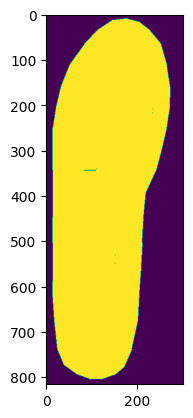

In [32]:
import matplotlib.pyplot as plt

filter_map = (arr_template > 0) * 1.0
plt.imshow(filter_map)
plt.show()

In [33]:
points_template = np.stack(np.where(filter_map > 0)).T[::50]
template_bound = points_template.max()
points_template = points_template / template_bound
len(points_template), template_bound, points_template

(3112,
 803,
 array([[0.01120797, 0.21793275],
        [0.01494396, 0.21046077],
        [0.01618929, 0.22042341],
        ...,
        [0.99750934, 0.12577833],
        [0.99875467, 0.13325031],
        [1.        , 0.14819427]]))

## Footprint sample

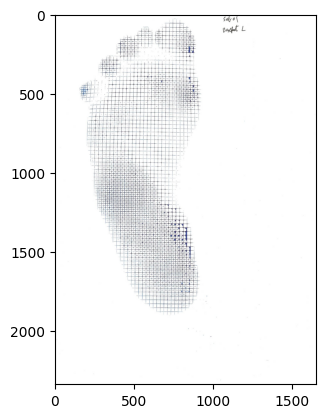

In [34]:
img_path = '/Users/knpob/Territory/Kolmo/data/footprint-to-pressure/footprint/S1-L.jpg'
img = plt.imread(img_path)
plt.imshow(img)
plt.show()

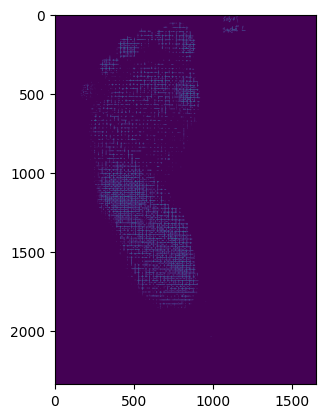

In [35]:
arr_img = np.array(img)
filter_thread = 50
filter_map = (np.mean(arr_img, axis=-1) < filter_thread) * 1.0
plt.imshow(filter_map)
plt.show()

In [36]:
points_footprint = np.stack(np.where(filter_map > 0)).T[::10]
footprint_bound = points_footprint.max()
points_footprint = points_footprint / footprint_bound
len(points_footprint), footprint_bound, points_footprint

(4147,
 1856,
 array([[0.00538793, 0.59428879],
        [0.0080819 , 0.61907328],
        [0.01023707, 0.57704741],
        ...,
        [0.99568966, 0.35775862],
        [0.99946121, 0.40678879],
        [1.        , 0.44127155]]))

## Rigid CPD registration

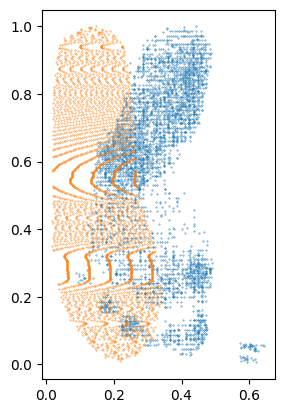

In [13]:
plt.scatter(points_footprint[:, 1], points_footprint[:, 0], s=0.1)
plt.scatter(points_template[:, 1], points_template[:, 0], s=0.1)
plt.gca().set_aspect('equal')
plt.show()

### Register template to footprint

In [17]:
from probreg import cpd

tf, _, _ = cpd.registration_cpd(points_template, points_footprint, 'rigid')
tf.rot, tf.scale, tf.t

(array([[ 0.99368263, -0.11222665],
        [ 0.11222665,  0.99368263]]),
 0.9719159592044927,
 array([0.03295404, 0.11912796]))

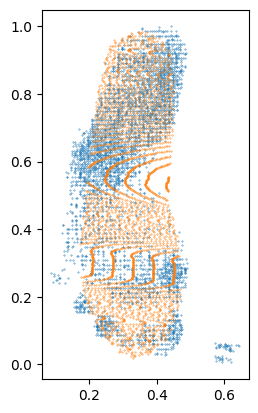

In [18]:
points_trans = tf.transform(points_template)

plt.scatter(points_footprint[:, 1], points_footprint[:, 0], s=0.1)
plt.scatter(points_trans[:, 1], points_trans[:, 0], s=0.1)
plt.gca().set_aspect('equal')
plt.show()

### Register footprint to template

In [19]:
from probreg import cpd

tf, _, _ = cpd.registration_cpd(points_footprint, points_template, 'rigid')
tf.scale, tf.rot, tf.t

(0.8926419555979014,
 array([[ 0.98562156,  0.16896787],
        [-0.16896787,  0.98562156]]),
 array([-0.00267226, -0.04728089]))

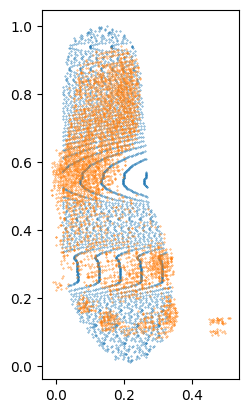

In [20]:
points_trans = tf.transform(points_footprint)

plt.scatter(points_template[:, 1], points_template[:, 0], s=0.1)
plt.scatter(points_trans[:, 1], points_trans[:, 0], s=0.1)
plt.gca().set_aspect('equal')
plt.show()

## Warp footprint to pedar plantar template